<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Neuropixels Dataset Exercises </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Wednesday, August 28, 2019</h3> 

<img src="../../resources/EphysObservatory/neuropixels.png" height="250" width="250"> 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys import ecephys_session
%matplotlib inline

# fix slow autocomplete
%config Completer.use_jedi = False

In [2]:
import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # OS X 
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2019/"
    data_root = "/run/media/tom.chartrand/Brain2019"

manifest_path = os.path.join(data_root, "dynamic-brain-workshop/visual_coding_neuropixels/2019/manifest.json")

# Exercises

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 1: Recordings across visual areas</b> 
<br>
Make raster plots for 20 units in each of the 6 visual areas ('VISp','VISl','VISal','VISrl','VISam','VISpm') for the first 5 minutes of the sessions.
<ol>
<li> Select a session that has data in all 6 areas
<li> Loop over these 6 areas
<li> Loop over 20 units per area, get their spike times, and plot them in a raster plot
</ol>
</div>

In [3]:
cache = EcephysProjectCache.fixed(manifest=manifest_path)
sessions = cache.get_sessions()

In [4]:
vis_areas = ['VISp','VISl','VISal','VISrl','VISam','VISpm']

In [5]:
vis_session_list = []
for session_id in sessions.index:
    session_areas = sessions.structure_acronyms.loc[session_id]
    vis_areas_in_session = [area for area in vis_areas if area in session_areas]
    if len(vis_areas_in_session)==6:
        vis_session_list.append(session_id)
print(vis_session_list)

[750749662, 755434585, 756029989]


In [6]:
# A more complex alternative solution to the above using some advanced features
all_areas = lambda session_areas : all(area in session_areas for area in vis_areas)
vis_session_list = list(sessions[sessions.structure_acronyms.apply(all_areas)].index.values)
print(vis_session_list)

[750749662, 755434585, 756029989]


In [7]:
session_id = vis_session_list[0]
session = cache.get_session_data(session_id)

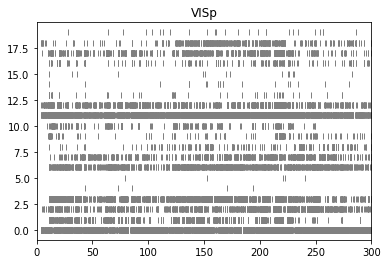

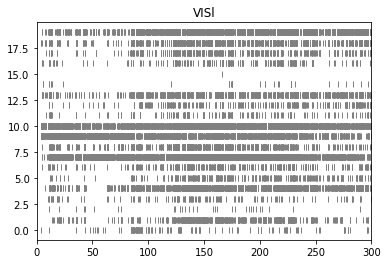

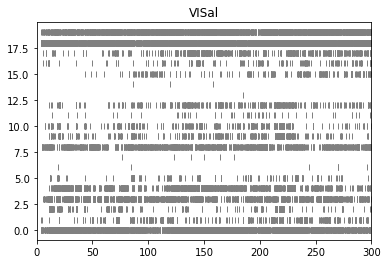

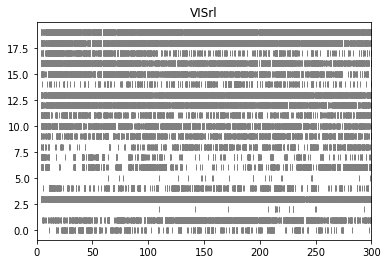

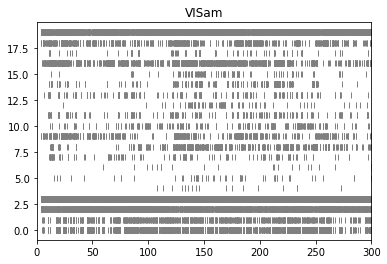

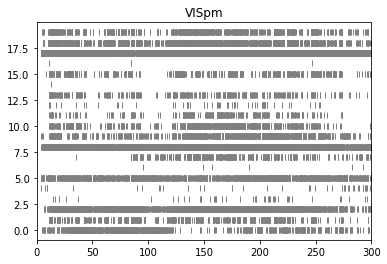

In [8]:
for i, area in enumerate(vis_areas):
    vis_unit_list = session.units[session.units.structure_acronym==area].index
    
    for i,unit in enumerate(vis_unit_list[:20]):
        spike_times =  session.spike_times[unit]                       
        plt.plot(spike_times, np.repeat(i, len(spike_times)), '|', color='gray') 
    plt.title(area) 
    plt.xlim(0,300)
    plt.show()

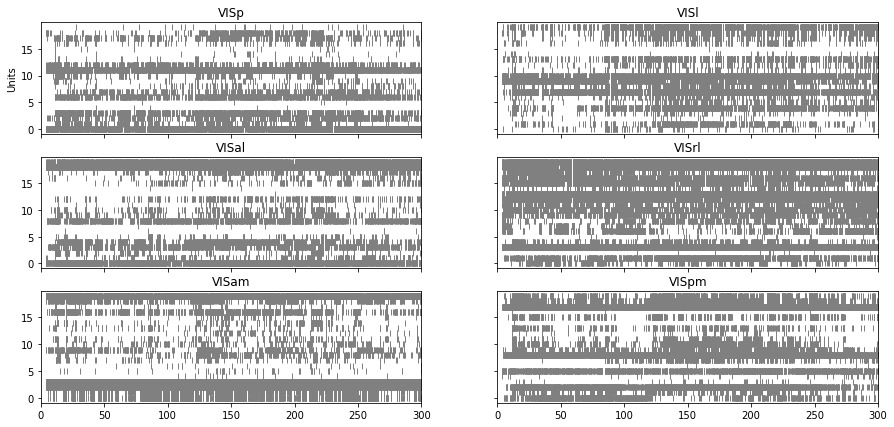

In [9]:
#To make this more compact, you can arrange subplots for each area as below:

fig,ax = plt.subplots(3,2,figsize=(15,7),sharex=True,sharey=True)

#The ravel command gets the six axes (3*2) into a single list.
ax = ax.ravel()     

for i_axis, area in enumerate(vis_areas):
    vis_unit_list = session.units[session.units.structure_acronym==area].index
    
    for i,unit in enumerate(vis_unit_list[:20]):
        spike_times =  session.spike_times[unit]                       
        ax[i_axis].plot(spike_times, np.repeat(i, len(spike_times)), '|', color='gray') 
    ax[i_axis].set_title(area)                           

        
plt.xlim(0,300)
ax[0].set_ylabel('Units')
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 2: ISI distributions</b>
<ol>
    <li>For a single unit, plot the inter-spike interval distribution with 1 ms bins. Show 2 graphs with different x-limits: (0, 20 ms) and (0, 200 ms).
    
</ol>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
  
Hints: Use the function np.diff to compute the difference between adjacent spike times (i.e. the inter-spike interval). 
</div>

In [10]:
unit_id = session.units.index.values[0]
unit_spikes = session.spike_times[unit_id]
isi = np.diff(unit_spikes)
isi = isi*1000 # convert to ms
print(isi[:20])

[ 659.2007334  2368.20263476 1513.5683506  2492.26943946 1005.46778531
  211.70023553  546.26727442  229.200255     61.43340168   22.03335785
   16.40001825    8.46667609  104.40011615   20.33335596  380.8670904
  126.16680703  117.96679791   93.06677021  980.66775772   63.3334038 ]


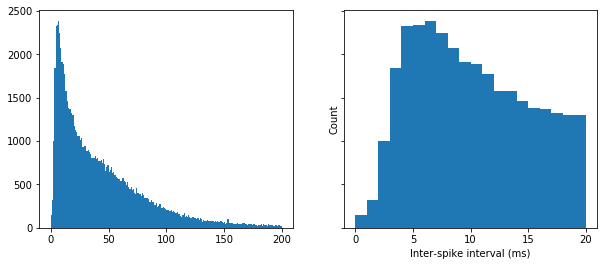

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax[0].hist(isi,bins=200,range=(0,200))
ax[1].hist(isi,bins=20,range=(0,20))
plt.ylabel('Count')
plt.xlabel('Inter-spike interval (ms)')
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 2 continued: ISI distributions</b>
<ol>
    <li>Get spike times for 50 units with highest SNR </li>
    <li>Provided that the unit has at least 3000 spikes, plot ISI distribution for each unit (a single plot each).</li>
    <li>How do the ISI distributions vary between cells?</li>
</ol>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
  
Hints:  `plt.subplots(...sharex=True)` will help keep all your subplots on the same scale automatically so they can be easily compared.
</div>

In [12]:
# Get units dataframe and filter by snr
snr_df = session.units.sort_values(by=['snr'], ascending=False)
snr_df.head()

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,channel_local_index,structure_acronym,structure_id,probe_horizontal_position,probe_id,probe_vertical_position,probe_description,lfp_sampling_rate,location,sampling_rate
unit_id,,,,,,,,,,,,,,,,,,,,,
914688159,0.457687,434.022810,0.000075,56,68.92,6.481973,5.083887,0.000000,85.628907,1.441867e-04,...,25,TH,549.0,11,769322806,260,probeC,2499.999495,,29999.993938
914687391,0.666301,590.849025,0.000003,103,168.86,16.786814,9.453318,0.000424,286.226803,0.000000e+00,...,150,DG,726.0,59,769322804,1520,probeB,2499.992895,,29999.914735
914686921,0.552406,481.059930,0.000244,310,105.35,7.123250,5.772334,0.000000,128.198911,2.432169e-07,...,285,VISam,394.0,11,769322802,2860,probeA,2499.997219,,29999.966623
914687191,0.593265,267.140250,0.000143,2,107.72,8.653586,10.106487,0.002225,96.752949,1.936972e-06,...,3,MB,313.0,27,769322804,40,probeB,2499.992895,,29999.914735
914688183,0.524359,290.970225,0.000154,68,67.07,6.419319,5.140892,0.012901,68.706724,1.126978e-03,...,30,TH,549.0,59,769322806,320,probeC,2499.999495,,29999.993938


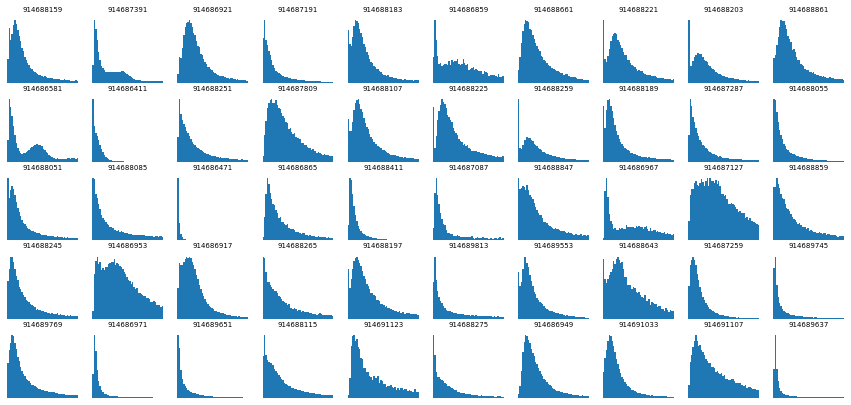

In [13]:
# Get spike times for 50 units with highest SNR
unit_list = snr_df.index.values[:50]

# Figure setup
fig,ax = plt.subplots(5,10,figsize=(15,7),sharex=True)
ax = ax.ravel()

# Plot ISI distribution for each unit
for i,unit in enumerate(unit_list):
    unit_spikes = session.spike_times[unit]
    if len(unit_spikes) > 3000:
        isi = np.diff(unit_spikes)
        ax[i].hist(isi,bins=50,range=(0,0.3))
        ax[i].set_title(str(unit_list[i]),fontsize=7)

plt.xlim(0,0.3)

for i in ax:
    i.axis('off')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 5: Explore responses to natural scenes</b> 
<ol>
    <li>Construct a stim_table for natural scenes, and use `get_stimulus_parameter_values` to list the possible values for all stimulus parameters. How many different images are presented? What do you think frame=-1 is?</li>
    <li>Use the presentationwise_spike_counts method to calculate the spike counts in 5 ms bins, for all presentations of a chosen image. Use a window extending one full stimulus presentation before and after the presentation of interest (showing three presentations total). Then take the mean across presentations to find the PSTH. 
    <li>Plot the histogram (as in step above) for all images separately.
    <li>Plot the image that drives the largest response for this unit.
    
</ol>
</div>

In [14]:
stim_table = session.get_presentations_for_stimulus('natural_scenes')
stim_ids = stim_table.index.values

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: natural_scenes
  warnings.warn(message)
/local1/storage/envs/allensdk3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [15]:
frames = session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids, drop_nulls=False)['frame']
frames = np.sort(frames)
frames

array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0,
       12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0,
       23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0,
       34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0,
       45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0,
       56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0,
       67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0,
       78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0,
       89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0,
       100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0,
       109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0],
      dtype=object)

In [16]:
stim_presentation_ids = stim_table[stim_table.frame==46].index.values

In [17]:
bin_width = 0.005
duration = stim_table.duration.mean()
pre_time = -duration
post_time = 2*duration
bins = np.arange(pre_time, post_time+bin_width, bin_width)   
    
histograms = session.presentationwise_spike_counts(
    bin_edges=bins,
    stimulus_presentation_ids=stim_presentation_ids,
    unit_ids=None
)
mean_histograms = histograms.mean(dim="stimulus_presentation_id")
rates = mean_histograms/bin_width

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:365: UserWarning: You've specified some overlapping time intervals between neighboring rows: [(16, 17)], with a maximum overlap of 0.5047942328919817 seconds.
  warnings.warn(f"You've specified some overlapping time intervals between neighboring rows: {overlapping}, "


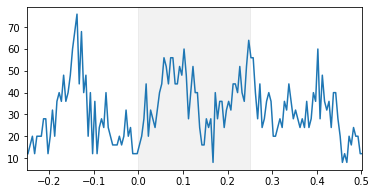

In [18]:
def plot_psth(unit_id, rates, ax=None, title=None):
    #Default params
    if not ax:
        fig,ax = plt.subplots(1,1,figsize=(6,3))
   
    rates.loc[{'unit_id':unit_id}].plot(ax=ax)
    ax.axvspan(0, duration, color='gray', alpha=0.1)
    ax.set_ylabel('Firing rate (spikes/second)')
    ax.set_xlabel('Time (s)')
    ax.set_xlim(pre_time,post_time)
    if ax:
        ax.set_title(title)
        ax.set_xlabel('')
        ax.set_ylabel('')


unit_id = 914686471#unit_list[0]
plot_psth(unit_id, rates)

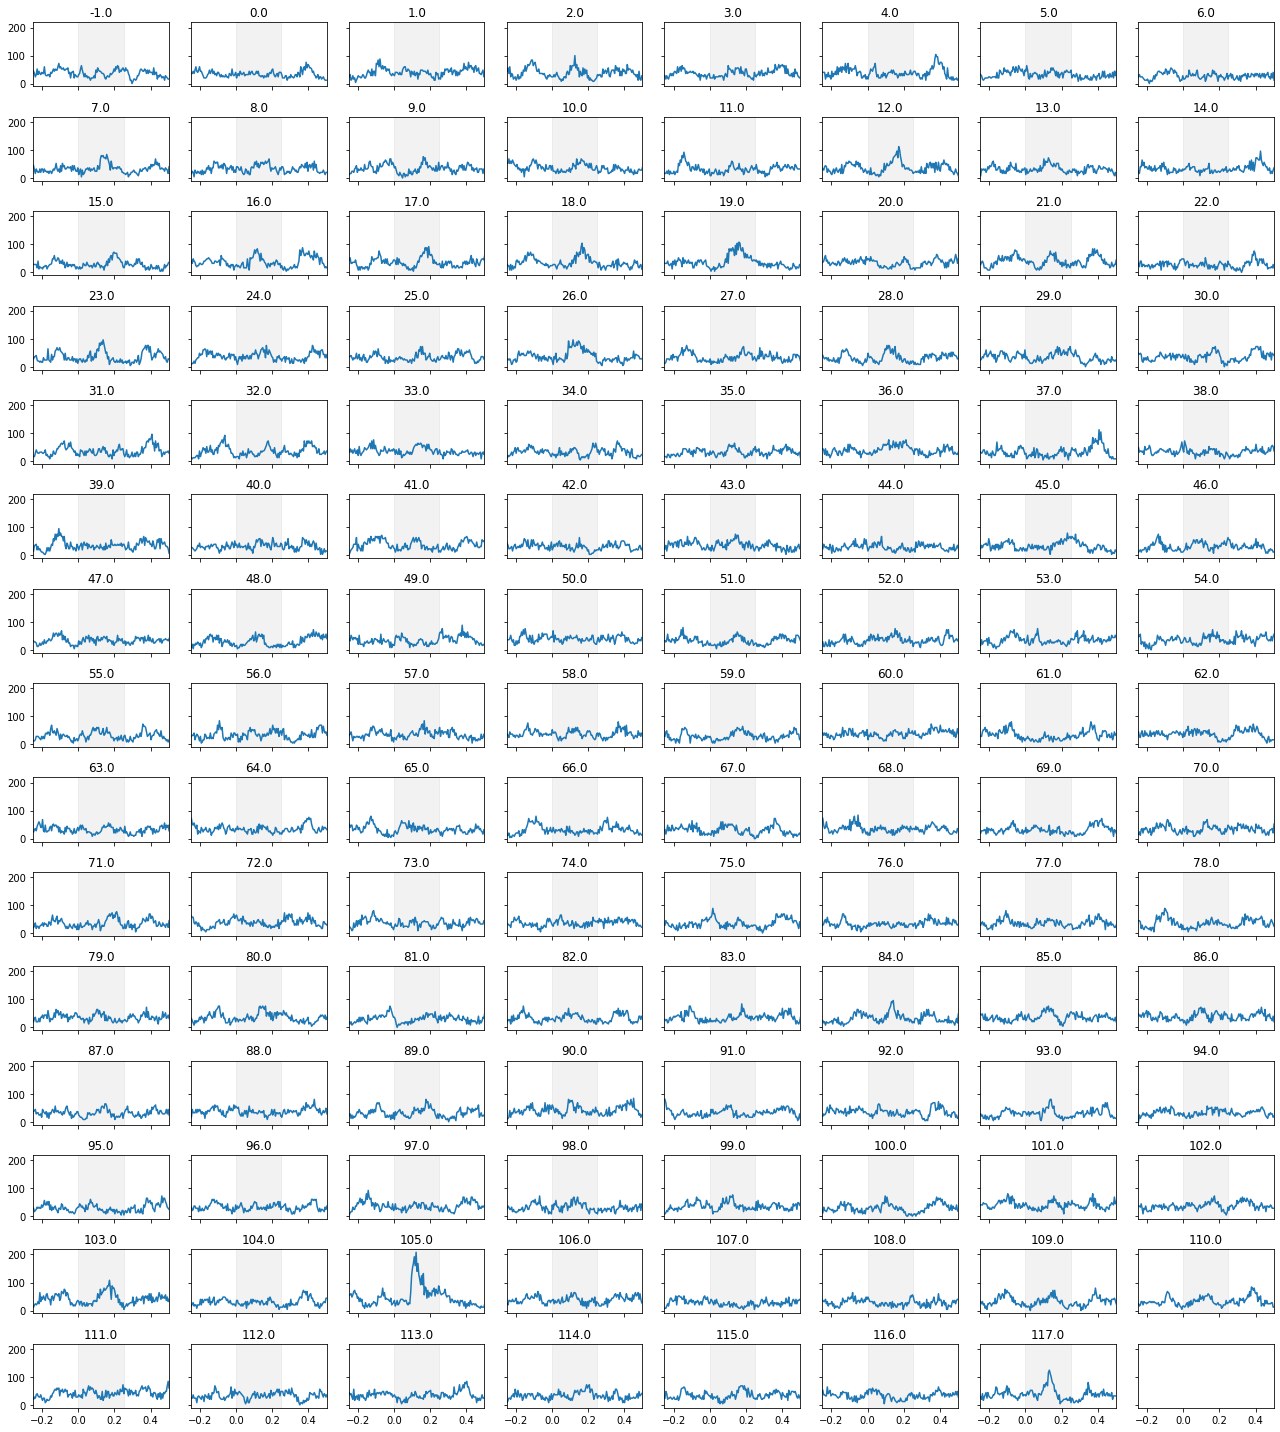

In [23]:
unit_id = 914686471
fig,ax = plt.subplots(15, 8, figsize=(18,20), sharex=True, sharey=True)
ax = ax.ravel()

# calculate histograms for all presentations at once - this may take a minute
histograms = session.presentationwise_spike_counts(
    bin_edges=bins,
    stimulus_presentation_ids=stim_table.index.values,
    unit_ids=None
    )

for i,frame in enumerate(frames):
    stim_presentation_ids = stim_table[stim_table.frame==frame].index.values
    
# select the histograms for this frame and average
    frame_histograms = histograms.loc[{'stimulus_presentation_id':stim_presentation_ids}]
    mean_histograms = frame_histograms.mean(dim="stimulus_presentation_id")
    rates = mean_histograms/bin_width
    
    plot_psth(unit_id, rates, ax=ax[i], title=frame)
plt.tight_layout()


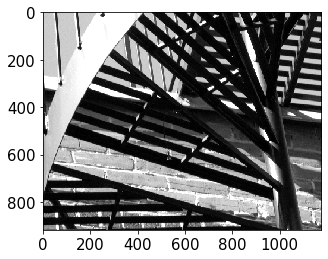

In [78]:
plt.imshow(cache.get_natural_scene_template(105), cmap='gray')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 5 continued: Explore responses to natural scenes</b> 
<ol>
    <li>Create a `conditionwise_spike_statistics` table for these stimuli.</li>
    <li>Plot the mean ± sem of the response to each image, add a dotted line (plt.axhline()) to represent the response to the blank sweep (frame=-1). Bonus: Use plt.axhspan() to shade the sem of the blanksweep. </li>

</ol>
</div>

In [79]:
spike_stats = session.conditionwise_spike_statistics(stimulus_presentation_ids=stim_ids, unit_ids=unit_list)

In [80]:
spike_stats.head()

,,spike_count,spike_mean,spike_sem,spike_std,stimulus_presentation_count
unit_id,stimulus_condition_id,,,,,
914686411,4908,576,11.52,0.617592,4.367038,50
914686471,4908,410,8.20,1.007725,7.125694,50
914686581,4908,44,0.88,0.150211,1.062150,50
914686859,4908,25,0.50,0.115175,0.814411,50
914686865,4908,8,0.16,0.072054,0.509502,50


In [81]:
unit_id = 914686471
response_mean = np.empty((len(frames)))
response_sem = np.empty((len(frames)))
for i,frame in enumerate(frames):
    stim_id = stim_table[stim_table.frame==frame].stimulus_condition_id.iloc[0]
    response_mean[i] = spike_stats.loc[(unit_id, stim_id)].spike_mean
    response_sem[i] = spike_stats.loc[(unit_id, stim_id)].spike_sem

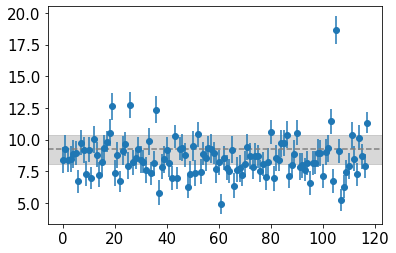

In [82]:
plt.errorbar(range(118), response_mean[1:], yerr=response_sem[1:], fmt='o')
plt.axhspan(response_mean[0]+response_sem[0], response_mean[0]-response_sem[0], color='gray', alpha=0.3)
plt.axhline(y=response_mean[0], color='gray', ls='--')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 5 continued: Explore responses to natural scenes</b> 
Some neurons have broad responses to lots of images, others respond only to a single or few images. One way to quantify this type of selectivity is using the <b>lifetime sparseness</b> metric. A high value of this metric indicates high selectivity - a differential response to one or a few stimulus conditions over others. A low value of this metric indicates a similar response across all conditions.   

<ol>
    <li>Compute the lifetime sparseness for the unit you plotted above.</li>
    <li>Extra credit: compute the lifetime sparseness for several units in your experiment. What's the range of values you see? Compare with the tuning plots you computed above for those neurons - make plots as the one directly above this and add the lifetime sparseness as a title.</li>

</ol>
</div>

In [27]:
#Lifetime sparseness is given by:

#sparseness = 1-(sum of trial averaged responses to images / N)squared / (sum of (squared mean responses / n)) / (1-(1/N))
# N = number of images
# after Vinje & Gallant, 2000; Froudarakis et al., 2014


In [28]:
response_norm = response_mean - response_mean[0]
N = float(len(response_norm))
ls = ((1-(1/N) * ((np.power(response_norm.sum(),2)) / (np.power(response_norm,2).sum()))) / (1-(1/N)))
print(ls)

0.8680807162367311


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 6: Population correlations and cross-correlograms of spiking activity</b>
<br>
The neural activity is often correlated between the neurons. The relationship between the activity of two units at different time lags is quantified by the cross-correlation. When the cross-correlation is plotted with respect to time lag, we call this a cross-correlogram.
<br>
We can also calculate a single correlation coefficient (at zero lag) for all pairs of recorded units, and visualize this using a matrix representation. In this exercise, you will compute the correlation matrix and compare it between different stimulus presentaitons.
<ol>
    <li>Correlations can be studied on many different timescales. Here we'll use a 10 ms timescale, so use `presentationwise_spike_counts` to create spike histograms for 10 ms time bins for both drifting gratings and spontaneous activity. Call the output 'histograms_drift' and 'histograms_spont'
    <li>Compute the cross_correlograms for two arbitatrary units during spontaneous activity and during drifting gratings presentation. Make sure you are using the same duration for the two stimulis as different stimuli have different length of presentation. Use the `scipy.signal.correlate` function to calculate the cross-correlation. Plot these cross_correlograms. How do they look different?
    
</ol>
</div>

In [29]:
# get the data for the drifting gratings

drift = session.get_presentations_for_stimulus('drifting_gratings')

# get the info about the drifting gratings session
first_drift_id = drift.index.values[0]
first_drift_duration = drift.loc[first_drift_id, "stop_time"] - drift.loc[first_drift_id, "start_time"]

# construct the time domain at 10 ms resolution
time_step = 1 / 100
time_domain = np.arange(0.0, first_drift_duration + time_step, time_step)

histograms_drift = session.presentationwise_spike_counts(
    bin_edges=time_domain,
    stimulus_presentation_ids=drift.index,
    unit_ids=None
)

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: drifting_gratings
  warnings.warn(message)


In [30]:
# get the data for the spontaneous activity

spont = session.get_presentations_for_stimulus('spontaneous')

# get the info about the first session of spontaneous acitivyt
first_spont_id = spont.index.values[0]
first_spont_duration = spont.loc[first_spont_id, "stop_time"] - spont.loc[first_spont_id, "start_time"]

# construct the time domain at 10 ms resolution
time_step = 1 / 100
time_domain = np.arange(0.0, first_spont_duration + time_step, time_step)

histograms_spont = session.presentationwise_spike_counts(
    bin_edges=time_domain,
    stimulus_presentation_ids=spont.index,
    unit_ids=None
)

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: spontaneous
  warnings.warn(message)


In [31]:
# get the spike histograms for the first presentation of each stimulus only
spike_counts_spont = histograms_spont[0]
spike_counts_drift = histograms_drift[0]


# be sure to use the equal amount of time for both histograms - use the duration of the drifting gratings
max_len=spike_counts_drift.shape[0]

# get two spike trains in spont activity
spike_train_1_spont=spike_counts_spont[:max_len, 1]
spike_train_2_spont=spike_counts_spont[:max_len, 2]

# get two spike trains in drifting gratings activity
spike_train_1_drift=spike_counts_drift[:max_len, 1]
spike_train_2_drift=spike_counts_drift[:max_len, 2]




Text(0.5, 0, 'Time bins (10 ms)')

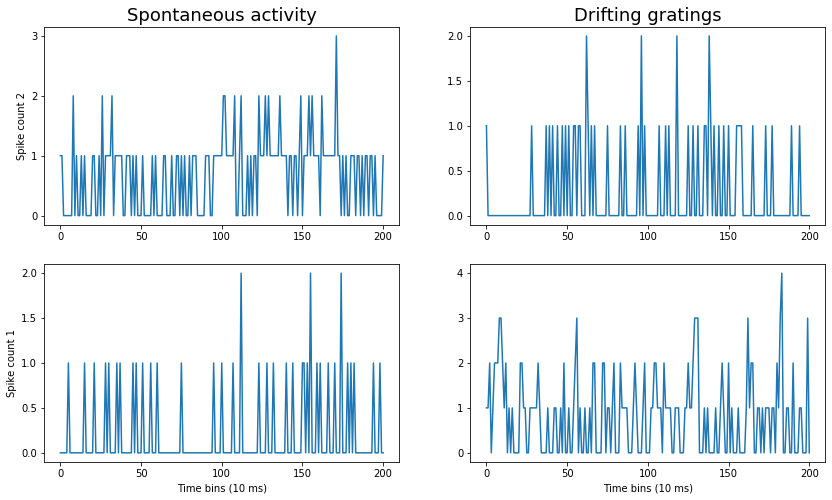

In [32]:
# plot the spike trains for which the correlogram will be computed

fig, axs = plt.subplots(2, 2,figsize=(14,8))
# update the figure size
plt.rcParams.update({'font.size': 15})

axs[0, 0].plot(spike_train_1_spont)
axs[0, 0].set_ylabel('Spike count 2')
axs[0, 0].set_title('Spontaneous activity')
axs[1, 0].plot(spike_train_2_spont)
axs[1 ,0].set_xlabel('Time bins (10 ms)')

axs[0, 1].plot(spike_train_1_drift)
axs[1, 0].set_ylabel('Spike count 1')
axs[0, 1].set_title('Drifting gratings')
axs[1, 1].plot(spike_train_2_drift)
axs[1 ,1].set_xlabel('Time bins (10 ms)')


In [33]:
import scipy.signal as signal

# compute the correlogram for spontaneous activity
xcorr_spont=signal.correlate(spike_train_1_spont,spike_train_2_spont)
xcorr_drift=signal.correlate(spike_train_1_drift,spike_train_2_drift)

# time steps
time_shift_spont=np.arange(-len(xcorr_spont)/2,len(xcorr_spont)/2,1)
time_shift_drift=np.arange(-len(xcorr_drift)/2,len(xcorr_drift)/2,1)


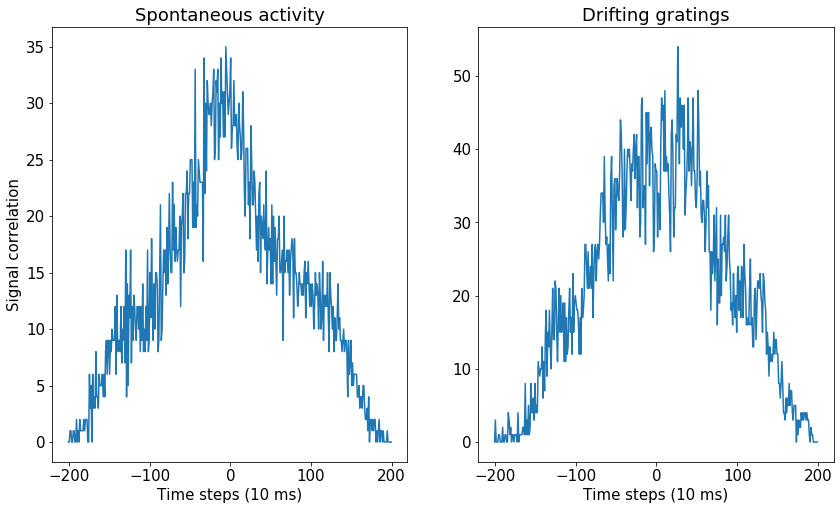

In [34]:
# plot the cross-correlations for spontaneous and drifting gratings

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.plot(time_shift_spont,xcorr_spont)
plt.ylabel('Signal correlation')
plt.xlabel('Time steps (10 ms)')
plt.title('Spontaneous activity')


plt.figure
plt.subplot(122)
plt.plot(time_shift_drift,xcorr_drift)
plt.xlabel('Time steps (10 ms)')
plt.title('Drifting gratings')
plt.show()


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 6 continued: Population correlations and cross-correlograms of spiking activity</b>
<br>
The neural activity is often correlated between the neurons. The relationship between the activity of two units at different time lags is quantified by the cross-correlation. When the cross-correlation is plotted with respect to time lag, we call this a cross-correlogram.
<br>
We can also calculate a single correlation coefficient (at zero lag) for all pairs of recorded units, and visualize this using a matrix representation. In this exercise, you will compute the correlation matrix and compare it between different stimulus presentaitons.
<ol>
    <li>Compute the linear pearson correlation coefficients for all pairs of the first 100 units, and store them as a correlation matrix. Use `scipy.stats.pearsonr` function. Visualise the matrix using imshow() command. Hint: if the values are constant, it makes sense to assume the correlation to be zero. </li>
    <li>Compare the correlation matrix structure for spontaneous actiivty and drifting gratings for the same units. Hint: to make it more clear, plot the correlations using log10(corr + 1) scaling.</li>
</ol>
</div>

In [35]:
import scipy.stats as stats

# make an array to hold the correlations for all units
num_units = 100
correlations_spont = np.zeros((num_units, num_units))
correlations_drift = np.zeros((num_units, num_units))

# compute correlations for the spontaneous activity
for ii in range(num_units):
    for jj in range(num_units):
        spike_train_1=spike_counts_spont[:max_len, ii]
        spike_train_2=spike_counts_spont[:max_len, jj]
        # we will compute only linear correlations
        correlations_spont[ii, jj] = stats.pearsonr(spike_train_1, spike_train_2)[0]
        # correlation for constant values is zero
        if np.isnan(correlations_spont[ii, jj]) == True:
            correlations_spont[ii, jj]=0

# compute correlations for drifting gratings
for ii in range(num_units):
    for jj in range(num_units):
        spike_train_1=spike_counts_drift[:max_len, ii]
        spike_train_2=spike_counts_drift[:max_len, jj]
        # we will compute only linear correlations
        correlations_drift[ii, jj] = stats.pearsonr(spike_train_1, spike_train_2)[0]
        # correlation for constant values is zero
        if np.isnan(correlations_drift[ii, jj]) == True:
            correlations_drift[ii, jj]=0
            

/local1/storage/envs/allensdk3/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


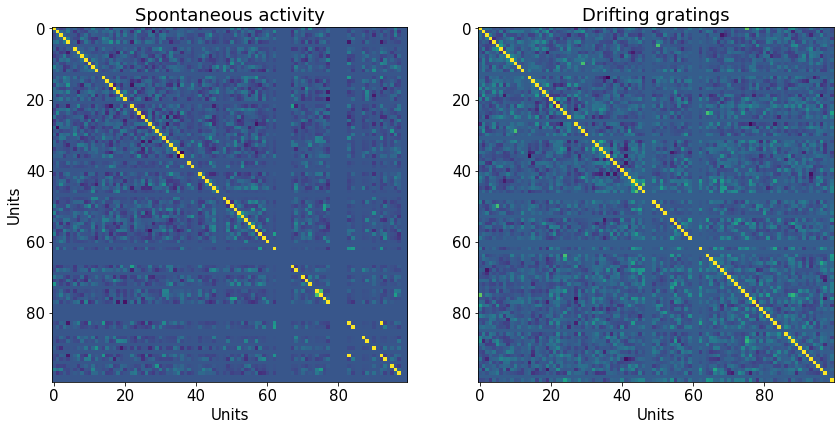

In [37]:
# plot correlation matrix with log10
# some units could be silent -> then there are no correlations

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(np.log10(correlations_spont+1))
plt.xlabel('Units')
plt.ylabel('Units')
plt.title('Spontaneous activity')


plt.subplot(122)
plt.imshow(np.log10(correlations_drift+1))
plt.title('Drifting gratings')
plt.xlabel('Units')
plt.show()


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 7: Spike waveform features</b> 
<br>Compute the spike duration for your selected list of units, and plot histogram of values.
<ol>
    <li>Concatenate waveforms in a matrix</li>
    <li>Compute location of trough and peak using np.argmax() and np.argmin()</li>
    <li>Compute difference between time of trough and peak</li>
    <li>Plot histogram of spikes duration (time between trough and peak)</li>
    <li>Bonus: construct a scatter plot comparing your results with the pre-calculated values in the units table, `session.units.waveform_duration`</li>
</ol>
</div>

In [38]:
peak_waveforms = []

for unit_id in unit_list:
    peak_ch = session.units.loc[unit_id, "peak_channel_id"]
    unit_mean_waveforms = session.mean_waveforms[unit_id]

    peak_waveforms.append(unit_mean_waveforms.loc[{"channel_id": peak_ch}])

In [39]:
# Concatenate waveforms into matrix
wv = np.array(peak_waveforms)

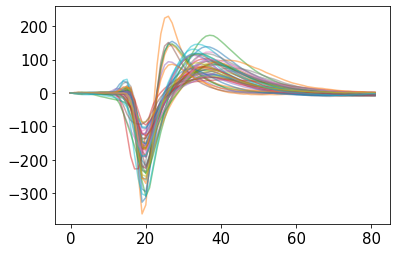

In [40]:
# Plot 100 waveforms in this data_set
fig,ax = plt.subplots(1,1,figsize=(6,4))
for w in wv[:100]:
    ax.plot(w,alpha=0.5)

In [41]:
# Compute trough-to-peak duration
duration_steps = np.argmax(wv,axis=1) - np.argmin(wv,axis=1)
# Pull the sampling rate from the units table and convert timesteps to ms
sampling_rate = session.units.loc[unit_list, "sampling_rate"]
duration = duration_steps/sampling_rate*1000

Text(0.5, 0, 'Spike duration (ms)')

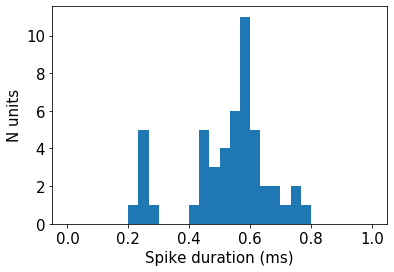

In [42]:
# Plot histogram of duration
plt.hist(duration, bins=30, range=(0,1));
plt.ylabel('N units')
plt.xlabel('Spike duration (ms)')

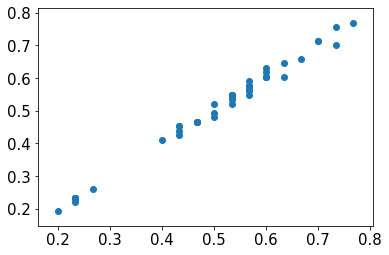

In [43]:
duration_stored = session.units.loc[unit_list, "waveform_duration"]
plt.scatter(duration, duration_stored)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 8: Spike-field relationships</b> 
<br>
The LFP is the product of the coordinated activity of a large number of cells localized near the probe, many more than those for which we have identified spikes. Thus, one way of understanding relationships between single neurons and the population is to look at relationships between spike times and the LFP. 
<br>
Here we will calculate the spike-triggered average of the LFP signal. If a certain pattern is repeated in the LFP whenever the cell fires, the averaging will help to isolate this signal and average out the noise. 
<ol>
    <li>Pick a unit, extract the LFP for the channel closest to it's peak channel, and select a subset of spikes to work with. (Working with the full dataset across channels and across all spiikes would take quite a while.) </li>
    <li>For each spike time of the unit, pick out a fixed window of the LFP aligned around the spike time. </li>
    <li>Average the windowed LFP signals to compute the spike-triggered average, and plot the results. Do you think this would look different if we had picked a channel further from the cell?</li>
</ol>
</div>

In [44]:
# Get spike times and channel info for a single unit
unit_id = session.units.index.values[0]
spikes = session.spike_times[unit_id]
peak_ch = session.units.loc[unit_id, "peak_channel_id"]
probe_id = session.units.loc[unit_id, "probe_id"]

In [45]:
lfp_full = session.get_lfp(probe_id)

In [46]:
channels = lfp_full.channel.values
channel_closest = channels[np.argmin(np.abs(channels-peak_ch))]

lfp_peak = lfp_full.loc[dict(channel=channel_closest)]

In [47]:
# Time before and after spike
pre_time = 1.
post_time = 1.
array_length = int(np.floor((pre_time+post_time)/(lfp_peak.time.values[1]-lfp_peak.time.values[0])))

# Make list that will contain the LFP around each spike
spike_triggered_lfp = []

spikes_subset = spikes[1000:-1000:50]
#Loop through every spike
for i, spike in enumerate(spikes_subset):
    
    t0 = spike - pre_time
    t1 = spike + post_time
    lfp_subset = lfp_peak.loc[dict(time=slice(t0, t1))].values[:array_length]
    
    spike_triggered_lfp.append(lfp_subset)

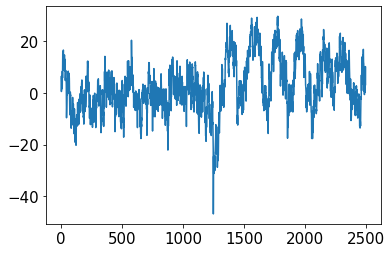

In [48]:
spike_triggered_lfp = np.array(spike_triggered_lfp)
sta_lfp = np.mean(spike_triggered_lfp, axis=0)

plt.plot(sta_lfp)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Exercise 9: Instantaneous phase of oscillatory LFP signals</b> 
<br>
Another way to analyze how an oscillatory signal varies with time is to extract its instantaneous amplitude using a mathematical tool called the Hilbert transform. The function `scipy.signal.hilbert` adds a second dimension to a signal (as a complex variable), such that the resulting *analytic signal* now has a well-defined nonzero amplitude and phase at every instant in time! (See http://www.rdgao.com/roemerhasit_Hilbert_Transform/ for a nice explanation.)
<br>
Note that these instantaneous amplitude and phase could be a starting point for more complex analysis of relationships between spike times and the LFP, or between LFP signals in different regions. We won't have time to get into that here!
<ol>
    <li>Working with a ~10 sec window of LFP from a single channel, find the peak frequency of the signal using the welsh periodogram.</li>
    <li>Filter the signal using the Butterworth filter, using a window of +/- 2 Hz around the peak frequency.</li>
    <li>Calculate the analytic signal from your filtered LFP </li>
    <li>Use `np.abs` and `np.angle` to calculate the amplitude and phase of the signal. Visualize the filtered LFP along with its amplitude and phase.</li>
</ol>
</div>

In [49]:
lfp_subset = lfp_peak.loc[dict(time=slice(10,20))]
v = lfp_subset.values
t = lfp_subset.time.values
fs = 1/(t[1]-t[0])

In [50]:
import scipy.signal
f, psd = scipy.signal.welch(v, fs, nperseg=1000)
f_peak = f[np.argmax(psd)]
print(f"peak frequency: {f_peak} Hz")

peak frequency: 6.249993046528965 Hz


In [51]:
freq_window = (f_peak-2, f_peak+2)
filt_order = 3
b, a = scipy.signal.butter(filt_order, freq_window, btype='bandpass', fs=fs)
v_filtered = scipy.signal.lfilter(b, a, v)

In [52]:
lfp_z = scipy.signal.hilbert(v_filtered)
lfp_amp = np.abs(lfp_z)
lfp_phase = np.angle(lfp_z)

Text(0, 0.5, 'Voltage (uV)')

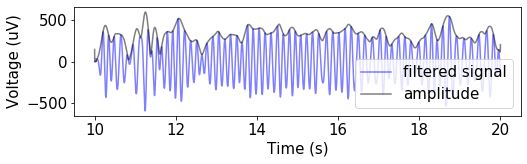

In [53]:
plt.figure(figsize=(8,2))
plt.plot(t, v_filtered,'b',label='filtered signal',alpha=.5)
plt.plot(t, lfp_amp,'k',label='amplitude',alpha=.5)
plt.legend(loc='best')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')

Text(0, 0.5, 'Phase (rad)')

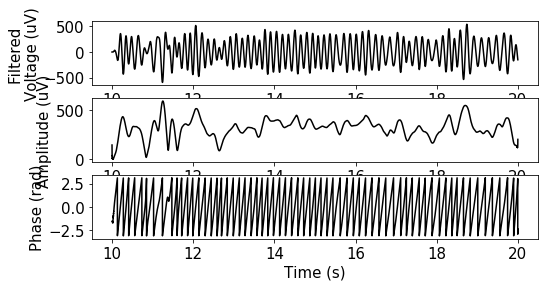

In [54]:
plt.figure(figsize=(8,4))
plt.subplot(3,1,1)
plt.plot(t, v_filtered,'k')
plt.ylabel('Filtered\nVoltage (uV)')
plt.subplot(3,1,2)
plt.plot(t, lfp_amp,'k')
plt.ylabel('Amplitude (uV)')
plt.subplot(3,1,3)
plt.plot(t, lfp_phase,'k')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<b>Bonus! Exercise 10: Explore tuning curves for static gratings, using seaborn plotting tools.</b> 
<ol>
    <li>Construct a stim_table for static gratings, and use `get_stimulus_parameter_values` to list the possible values for all stimulus parameters.</li>
    <li>Create a `presentationwise_spike_counts` table for these stimuli, using a single bin covering the full duration of the presentation. Convert the output to a dataframe (`to_dataframe` method), and merge to the stim table to link the spike counts to the stimulus parameters.</li>
    <li>Follow the examples below to show the tuning of the cell across two and three dimensions of stimulus parameters, respectively.</li>
    <li>Explore variations on these plots by changing which columns are assigned to the `x`, `hue`, and `col` parameters. You can also show a single plot with one stimulus parameter left out to aggregate across that parameter. Which combination do you feel represents the data most intuitively? (We'll always want to keep `y="spike_counts"`, since that is the dependent variable here.)</li>
    <li>If you have time, follow the same steps for driting gratings for the same cell and compare the results.</li>
</ol>
</div>

In [55]:
stim_table = session.get_presentations_for_stimulus('static_gratings')
stim_ids = stim_table.index.values

session.get_stimulus_parameter_values(stimulus_presentation_ids=stim_ids)

/home/tom.chartrand/work/AllenSDK/allensdk/brain_observatory/ecephys/ecephys_session.py:878: UserWarning: expected stimulus_names to be a collection (list-like), but found <class 'str'>: static_gratings
  warnings.warn(message)


{'contrast': array([0.8], dtype=object),
 'orientation': array([0.0, 30.0, 60.0, 90.0, 120.0, 150.0], dtype=object),
 'phase': array([0.0, 0.25, 0.5, 0.75], dtype=object),
 'spatial_frequency': array([0.02, 0.04, 0.08, 0.16, 0.32], dtype=object)}

In [56]:
bin_edges = [0, stim_table.duration.min()]
spike_stats = session.presentationwise_spike_counts(bin_edges,stimulus_presentation_ids=stim_ids, unit_ids=unit_list)
spike_stats = spike_stats.to_dataframe().reset_index()
spike_stats = pd.merge(spike_stats, stim_table, on='stimulus_presentation_id', right_index=True)

In [57]:
spike_stats.head()

,stimulus_presentation_id,time_relative_to_stimulus_onset,unit_id,spike_counts,contrast,orientation,phase,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,duration,stimulus_condition_id
0,49434,0.125096,914688159,2,0.8,30,0.5,0.02,5398.755799,8,static_gratings,5399.006002,0.250203,4787
1,49434,0.125096,914687391,1,0.8,30,0.5,0.02,5398.755799,8,static_gratings,5399.006002,0.250203,4787
2,49434,0.125096,914686921,1,0.8,30,0.5,0.02,5398.755799,8,static_gratings,5399.006002,0.250203,4787
3,49434,0.125096,914687191,3,0.8,30,0.5,0.02,5398.755799,8,static_gratings,5399.006002,0.250203,4787
4,49434,0.125096,914688183,1,0.8,30,0.5,0.02,5398.755799,8,static_gratings,5399.006002,0.250203,4787


**Hint: Tuning across two stimulus dimensions**

First, assign to the variable `data` a subset of the spike counts dataframe for a specific unit id and spatial frequency. Then run the code below.

In [64]:
unit_id = 914686471
data = spike_stats[(spike_stats.unit_id==unit_id) & (spike_stats.spatial_frequency==0.16)]

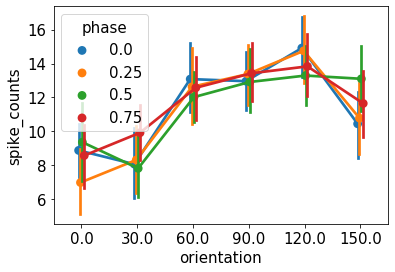

In [65]:
import seaborn as sns
y = "spike_counts"
x = "orientation"
hue = "phase"
sns.pointplot(data=data, x=x, y=y, hue=hue, dodge=True)

**Hint: Tuning across three stimulus dimensions**

This time, assign to the variable `data` a subset of the spike counts dataframe containing all data for a single unit. Then run the code below.

In [66]:
data = spike_stats[(spike_stats.unit_id==unit_id)]

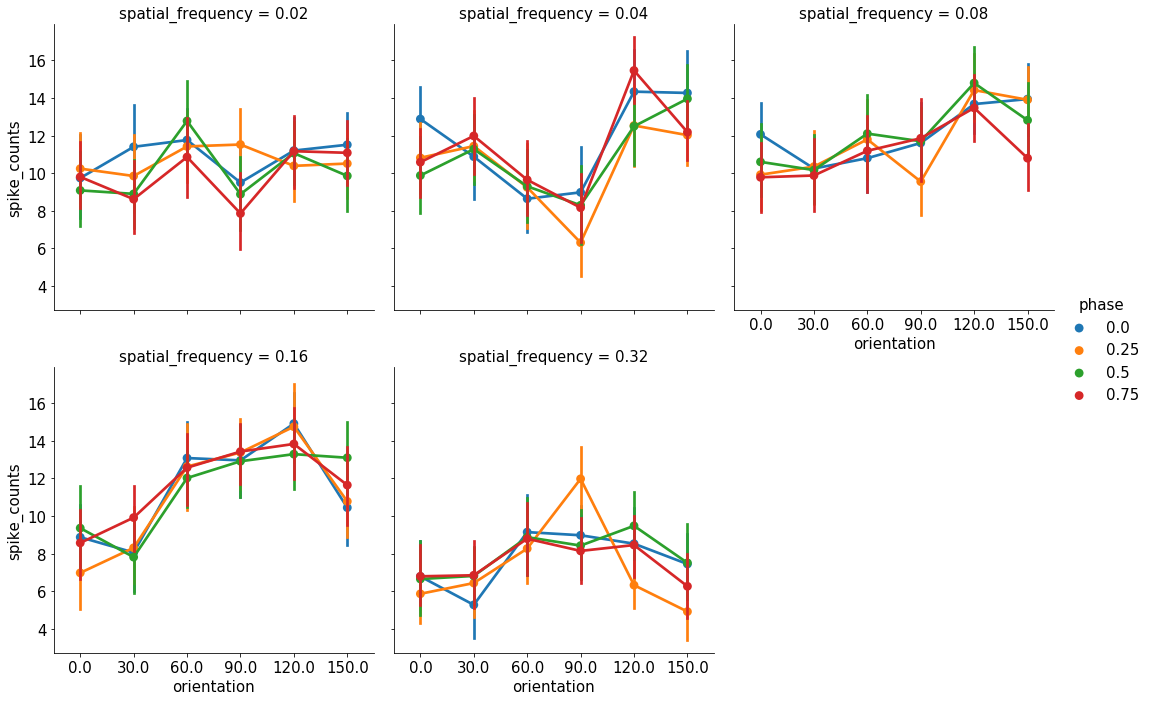

In [67]:
# We want to ignore the 'null' sweeps. By setting them to NaN, seaborn will automatically ignore them.
data = data.replace('null', np.nan)
y = "spike_counts"
x = "orientation"
hue = "phase"
col = "spatial_frequency"
sns.catplot(data=data, col=col, x=x, y=y, hue=hue, col_wrap=3, kind='point')